In [1]:
import Ipynb_importer
import torchvision
import glob
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
from mydataset import myDataset
from model import LeNet
import matplotlib.pyplot as plt
%matplotlib inline

importing Jupyter notebook from mydataset.ipynb
importing Jupyter notebook from getCifarImg2Disk.ipynb
importing Jupyter notebook from model.ipynb


In [2]:
"""
定义超参数
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epoch_num = 50
lr = 0.001
batch_size = 64
best_test_acc = 0.0
model = LeNet()
model = model.to(device)

In [3]:
"""
定义绘图参数
"""
train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []
epochs_list = []

In [4]:
"""
获取数据
"""

# 用Compose串联多个数据增强操作
train_transform = transforms.Compose([
    # ToTensor()将shape为(H, W, C)的nump.ndarray或img转为shape为(C, H, W)的tensor，其将每一个数值归一化到[0,1]
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    # 标准化：再使用公式"(x-mean)/std"，将每个元素分布到(-1,1)
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

img_train_list = glob.glob("data/train/*/*.png")
img_test_list = glob.glob("data/test/*/*.png")

train_dataset = myDataset(img_train_list, transform=train_transform)
test_dataset = myDataset(img_test_list, transform=test_transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

test_data_iter = iter(test_loader)
test_image, test_label = test_data_iter.next()

In [5]:
"""
loss定义
"""
loss_func = nn.CrossEntropyLoss()
"""
optimizer定义
"""
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [6]:
def test():
    global best_test_acc
    running_loss = 0
    correct = 0 #已经预测结束且预测正确的样本数，初始化为0
    total = 0 #已经预测结束的样本数，初始化为0
    
    model.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            loss = loss_func(outputs, labels)
            running_loss += loss.item()
            
            _,pred = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (pred==labels).sum().item()
            test_accu = correct / total
        
        if test_accu > best_test_acc:
            best_test_acc = test_accu
        
        test_acc_list.append(test_accu)
        test_loss_list.append(running_loss / len(test_dataset))
        
        print(f"[Test Loss]:{running_loss / len(test_dataset):3f}\t[Test Accurary]:{(test_accu * 100):3f}%")

In [7]:
def train():
    running_loss = 0
    correct = 0 #已经预测结束且预测正确的样本数，初始化为0
    total = 0 #已经预测结束的样本数，初始化为0
    
    model.train()
    for batch_idx, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() # 梯度清零
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward() #反馈
        optimizer.step() #更新参数
        
        
        _,pred = torch.max(outputs.data, dim=1)
        total += labels.size(0)
        correct += (pred==labels).sum().item()
        train_accu = correct / total
        
        running_loss += loss.item()
        
    train_acc_list.append(train_accu)
    train_loss_list.append(running_loss / len(train_dataset))
    
    print(f"[Train Loss]:{running_loss / len(train_dataset):3f}\t[Train Accurary]:{(train_accu * 100):2f}%")

In [8]:
def showAcc():
    plt.figure()
    plt.plot(epochs_list,test_acc_list,color="red",label="test_acc")
    plt.plot(epochs_list,train_acc_list,color="green",label="train_acc")
    plt.xlabel("epochs")
    plt.ylabel("Acc")
    plt.title('Accurary:LeNet in CIFA10')
    plt.xticks([i for i in range(0,len(epochs_list),20)])
    acc_gap=[i*0.2 for i in range(0,min(int(len(epochs_list)/2+1),6))]
    acc_gap.append(max(test_acc_list))
    acc_gap.append(max(train_acc_list))
    plt.yticks(acc_gap)
    plt.grid()
    plt.legend()
    plt.savefig("./data/AccOfLeNet.jpg")
    return

In [9]:
def showLoss():
    plt.figure()
    plt.plot(epochs_list,test_loss_list,color="red",label="test_loss")
    plt.plot(epochs_list,train_loss_list,color="green",label="train_loss")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.title('Loss:LeNet in CIFA10')
    plt.xticks([i for i in range(0,len(epochs_list),20)])
    plt.grid()
    plt.legend()
    plt.savefig("./data/LossOfLeNet.jpg")
    return

In [10]:
def main():
    global best_test_acc
    for epoch in range(epoch_num):
        epochs_list.append(epoch)
        print(f"**********************[Epoch:{epoch+1}]**********************")
        
        train()
        test()
        
    print(f"[Best Test Accuracy]:{(best_test_acc * 100):3f}%")
    showAcc()
    showLoss()

**********************[Epoch:1]**********************
[Train Loss]:0.026325	[Train Accurary]:38.030000%
[Test Loss]:0.022447	[Test Accurary]:47.805000%
**********************[Epoch:2]**********************
[Train Loss]:0.021740	[Train Accurary]:50.024000%
[Test Loss]:0.020111	[Test Accurary]:53.713333%
**********************[Epoch:3]**********************
[Train Loss]:0.019528	[Train Accurary]:55.598000%
[Test Loss]:0.018928	[Test Accurary]:56.448333%
**********************[Epoch:4]**********************
[Train Loss]:0.018112	[Train Accurary]:58.724000%
[Test Loss]:0.017492	[Test Accurary]:60.261667%
**********************[Epoch:5]**********************
[Train Loss]:0.017139	[Train Accurary]:61.250000%
[Test Loss]:0.016620	[Test Accurary]:62.098333%
**********************[Epoch:6]**********************
[Train Loss]:0.016350	[Train Accurary]:62.828000%
[Test Loss]:0.015723	[Test Accurary]:64.270000%
**********************[Epoch:7]**********************
[Train Loss]:0.015769	[Train Accur

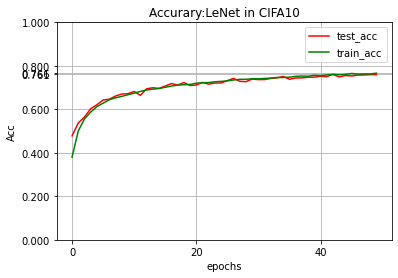

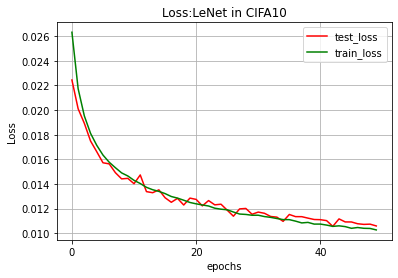

In [11]:
main()